In [1]:
from typing import *
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, transpile
sim = AerSimulator()

from util import zero, one

# QC: Grover's Algorithm

**Under Construction**

In [2]:
n = 3
N = 2**n
marked_state = "010"

### Visualization

We introduce a visualization the tracks the "probability" amplitudes of the quantum state as Grover's search is applied. The marked state that we are searching for is given in red. Every other state is given in blue.

In [3]:
def plot_amplitudes(q: Statevector, marked_state: str) -> None:
    real_amps = [q.data[i].real for i in range(len(q))]
    plt.figure(figsize=(8, 2))
    N = len(real_amps)
    x_axis = np.arange(0, N, 1)
    colors = ["blue"] * N
    colors[int(marked_state, 2)] = "red"
    n = int(math.log2(N))
    axis_labels = [format(i, f"0{n}b") for i in range(2**n)]
    plt.grid()
    plt.bar(x_axis, real_amps, width=0.25, tick_label=axis_labels, color=colors)
    plt.ylim(-1, 1)

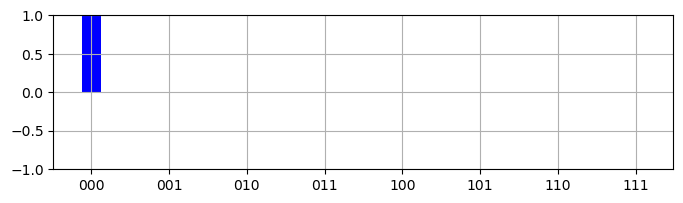

In [4]:
plot_amplitudes(zero ^ zero ^ zero, marked_state)

### Step 1: Put first n qubits in superposition

Our first step is to put the $n$ qubits in superposition. As usual, we will accomplish this by applying Hadamard gates to all qubits.

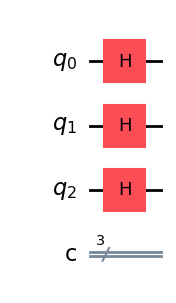

In [5]:
qc = QuantumCircuit(n, n)
qc.h(range(n))
qc.draw(output="mpl", style="iqp")

#### State after step 1

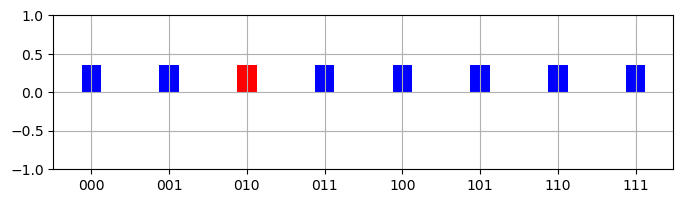

In [6]:
s2 = (zero ^ zero ^ zero).evolve(Operator(qc))
plot_amplitudes(s2, marked_state)

### Step 2: Apply Grover's Diffuser

We will iteratively apply **Grover's diffuser**, which consists of two steps:
1. applying **Grover's oracle** and
2. applying an **amplification** step.

#### Step 2.1: Apply Oracle

In [7]:
def grover_oracle(qc, marked_state):    
    n_qubits = qc.num_qubits
    # Apply X gates to qubits that should be |0⟩ in the marked state
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    
    # ---- MCZ -----
    qc.h(n_qubits - 1)  # Change the target qubit to the |-| state
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)  # Multi-controlled X with n-1 controls
    qc.h(n_qubits - 1)  # Undo the |-| state
    # ---- MCZ -----
    
    # Apply X gates again to revert the qubits to their original state
    for i, bit in enumerate(marked_state):
        if bit == '0':
            qc.x(i)

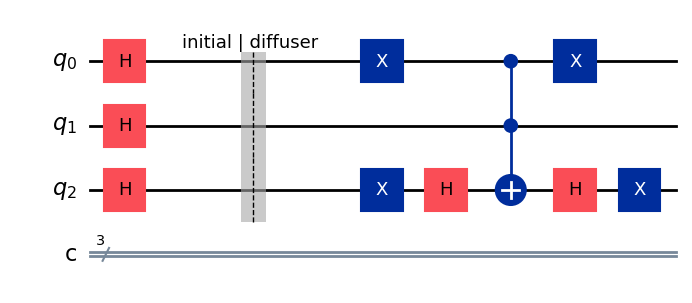

In [8]:
qc.barrier(label="initial | diffuser ")
grover_oracle(qc, marked_state)
qc.draw(output="mpl", style="iqp")

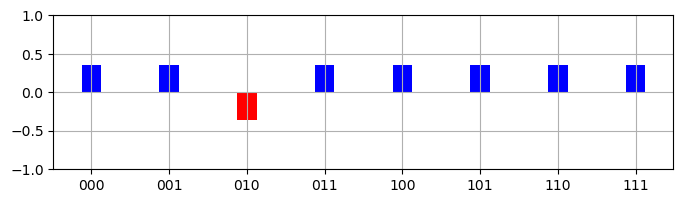

In [9]:
s3 = (zero ^ zero ^ zero).evolve(Operator(qc))
plot_amplitudes(s3, marked_state)

#### Step 2.2: Amplification



In [10]:
def grover_diffuser(qc):    
    n_qubits = qc.num_qubits
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    
    # ---- MCZ -----
    qc.h(n_qubits - 1)  # Change the target qubit to the |-| state
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)  # Multi-controlled X with n-1 controls
    qc.h(n_qubits - 1)  # Undo the |-| state
    # ---- MCZ -----
    
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    
    return qc

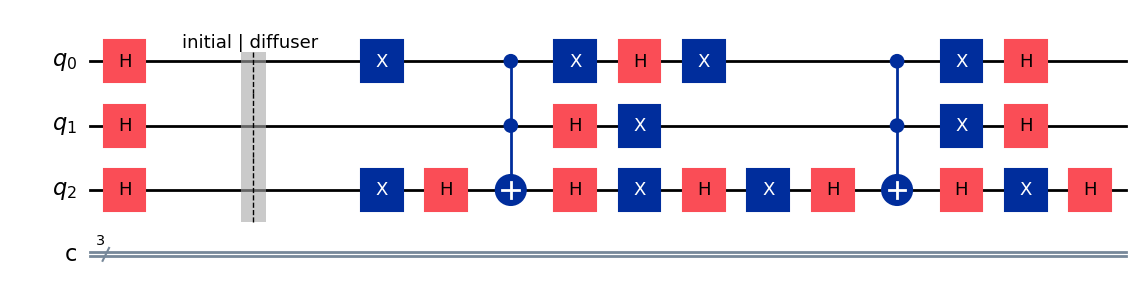

In [11]:
grover_diffuser(qc)
qc.draw(output="mpl", style="iqp")

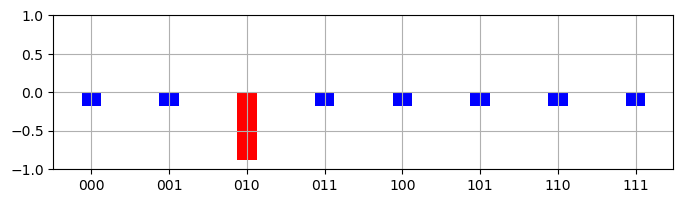

In [12]:
s4 = (zero ^ zero ^ zero).evolve(Operator(qc))
plot_amplitudes(s4, marked_state)

#### How many iterations?



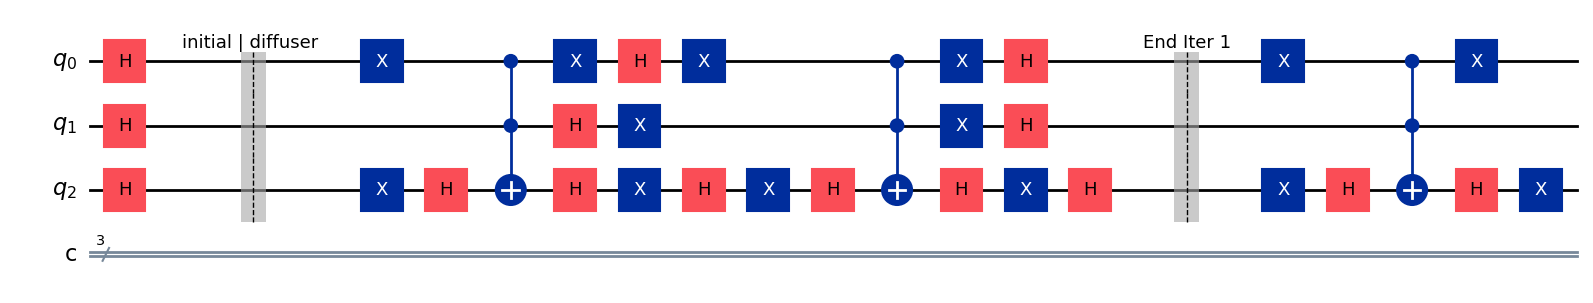

In [13]:
qc.barrier(label=f"End Iter {1}")
grover_oracle(qc, marked_state)
qc.draw(output="mpl", style="iqp")

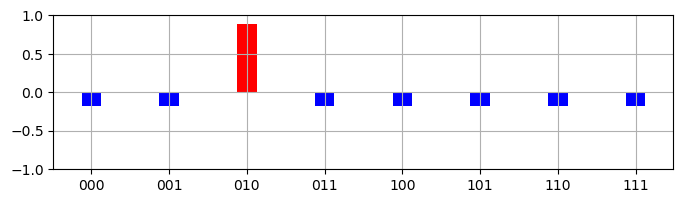

In [14]:
s5 = (zero ^ zero ^ zero).evolve(Operator(qc))
plot_amplitudes(s5, marked_state)

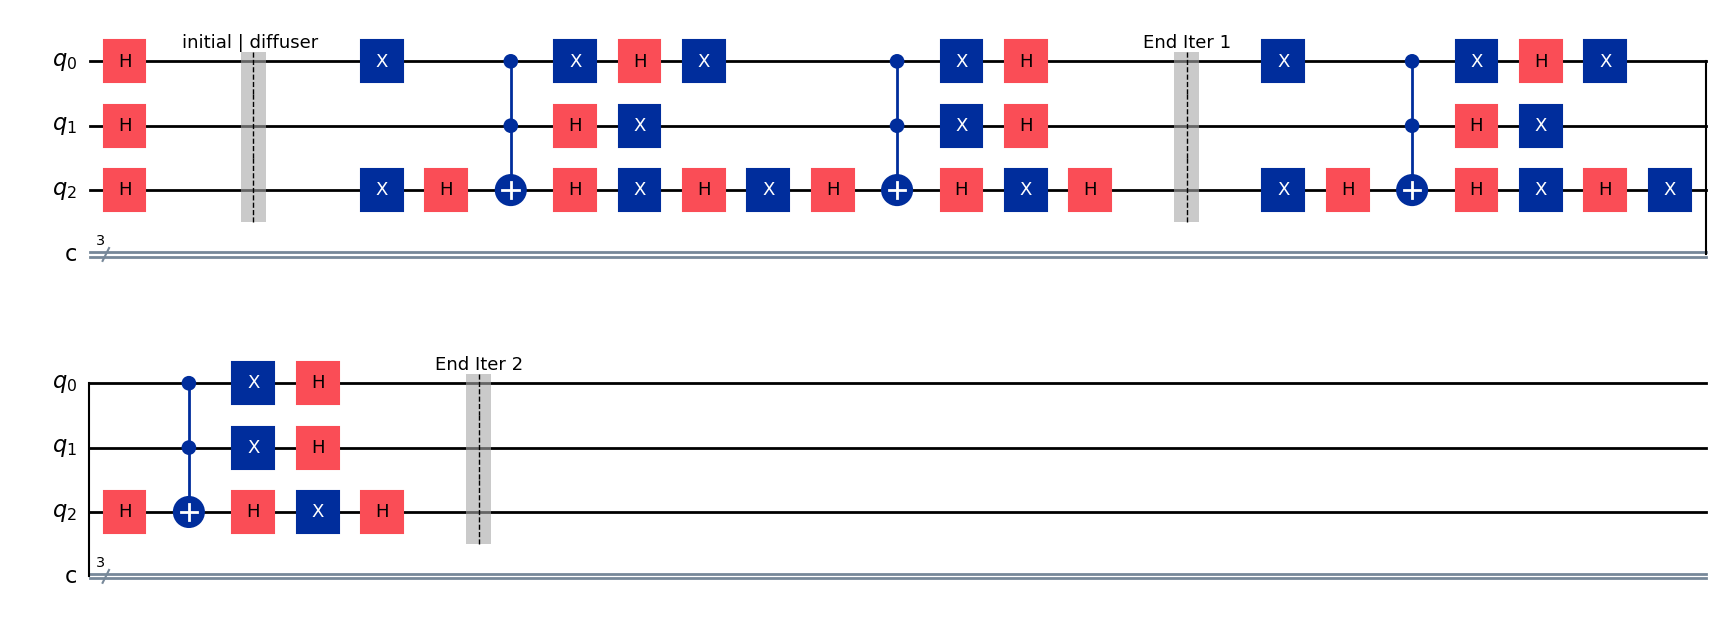

In [15]:
grover_diffuser(qc)
qc.barrier(label=f"End Iter {2}")
qc.draw(output="mpl", style="iqp")

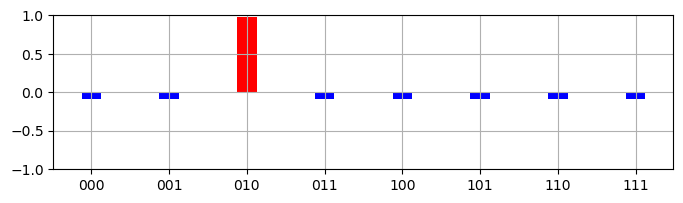

In [16]:
s6 = (zero ^ zero ^ zero).evolve(Operator(qc))
plot_amplitudes(s6, marked_state)

### Step 3: Measure

In [17]:
def grover_measure(qc):
    for n in range(qc.num_qubits):
        qc.measure(n, n)

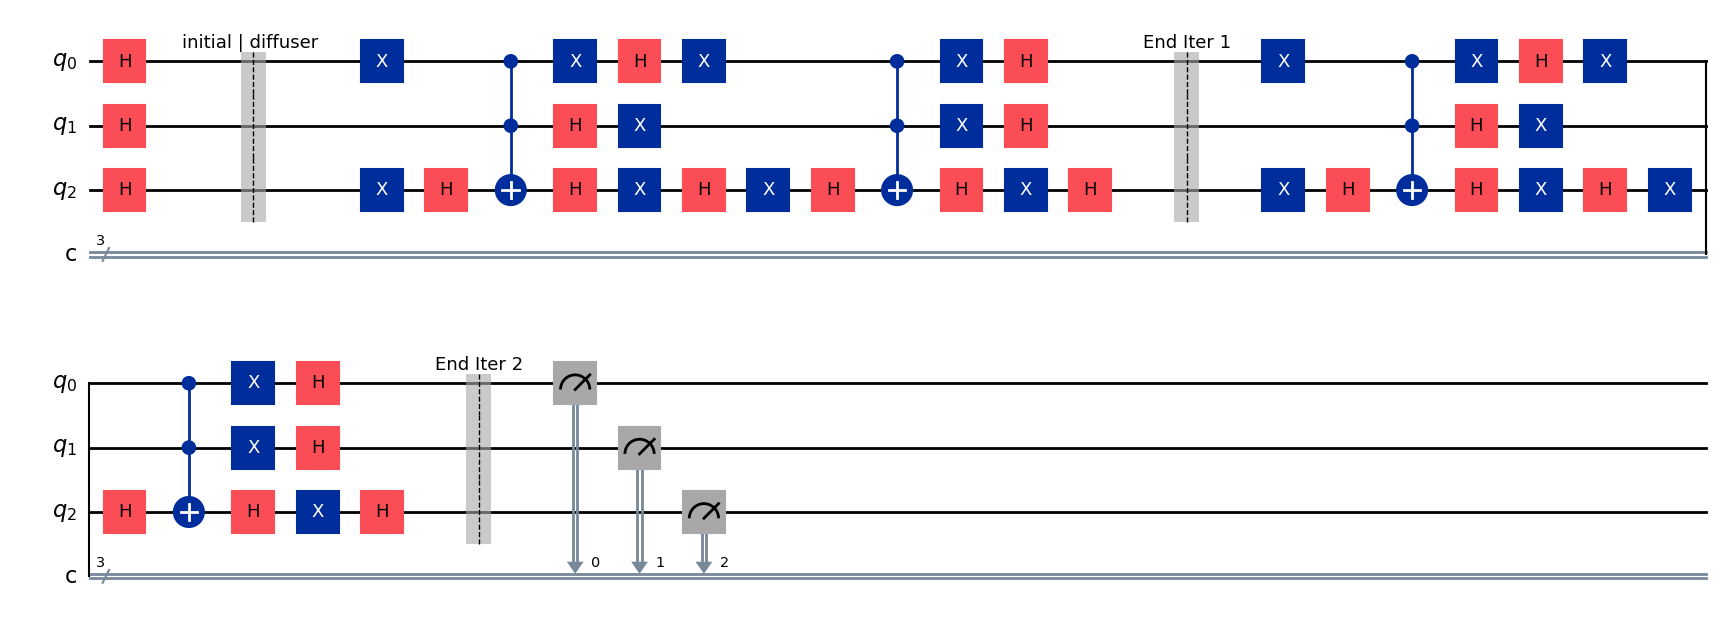

In [18]:
grover_measure(qc)
qc.draw(output="mpl", style="iqp")

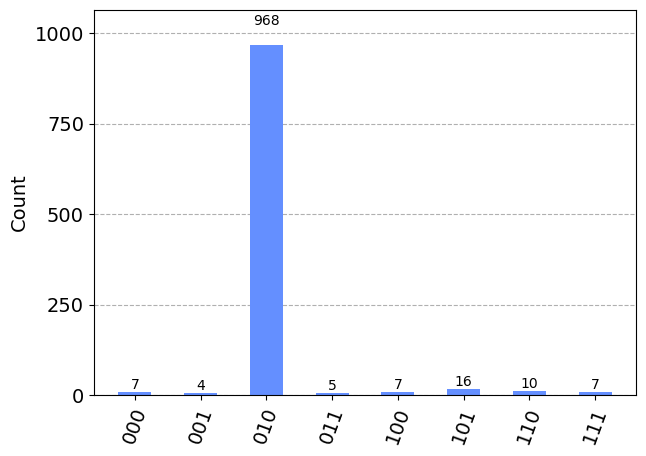

In [19]:
t_qc = transpile(qc, sim)
results = sim.run(t_qc, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

### Putting it all together

In [20]:
def grovers(n_qubit, marked_state):
    qc = QuantumCircuit(n_qubit, n_qubit)
    
    # Step 1
    qc.h(range(n_qubit))
    
    # Step 2
    num_iter = int(np.floor(np.pi / 4 * np.sqrt(2 ** n_qubit)))
    qc.barrier(label="Step 1|Step 2: Diffuser")
    for i in range(num_iter):
        # Step 2.1
        grover_oracle(qc, marked_state)
        
        qc.barrier(label=f"Oracle | Amp")
        # Step 2.2
        grover_diffuser(qc)
        qc.barrier(label=f"End Iter {i+1}")

    # Step 3
    grover_measure(qc)
        
    return qc

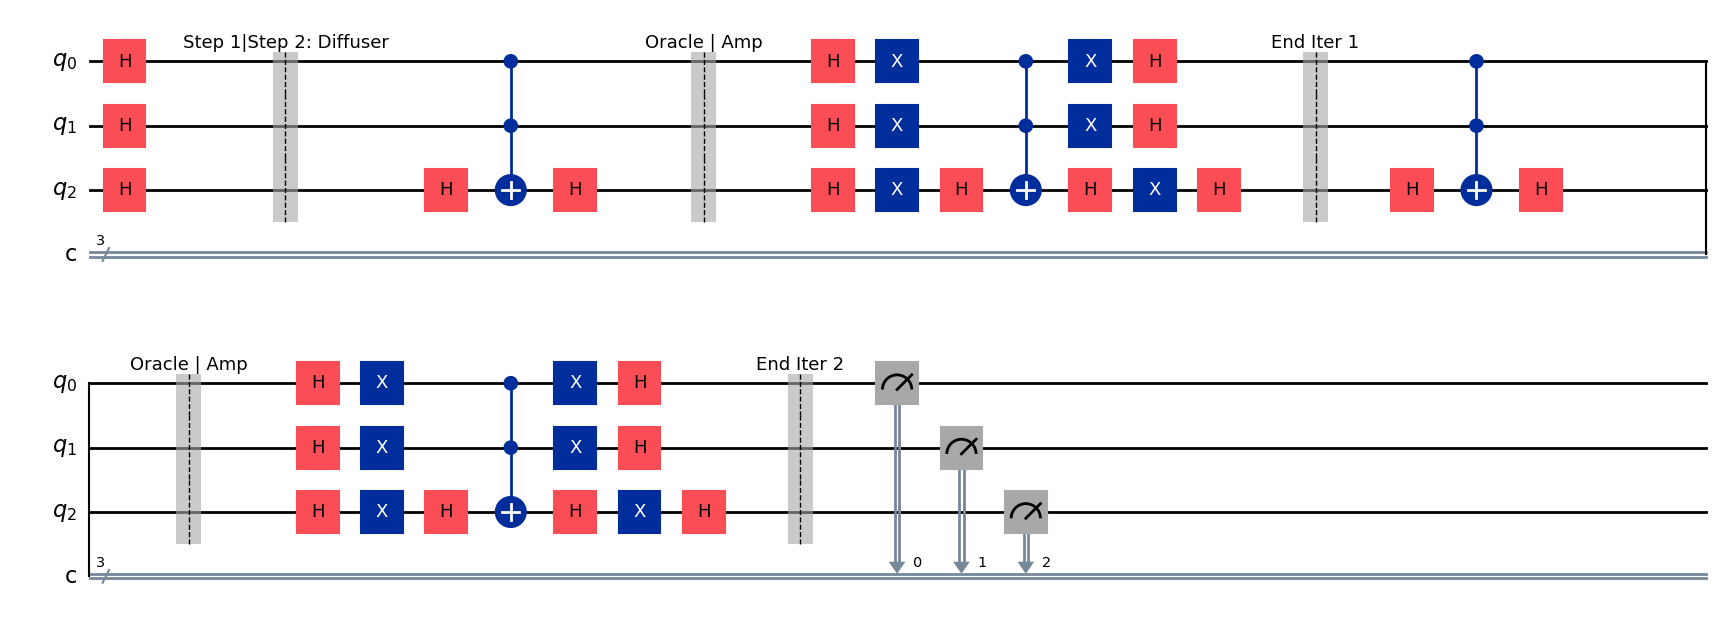

In [21]:
qc = grovers(3, "111")
qc.draw(output="mpl", style="iqp")

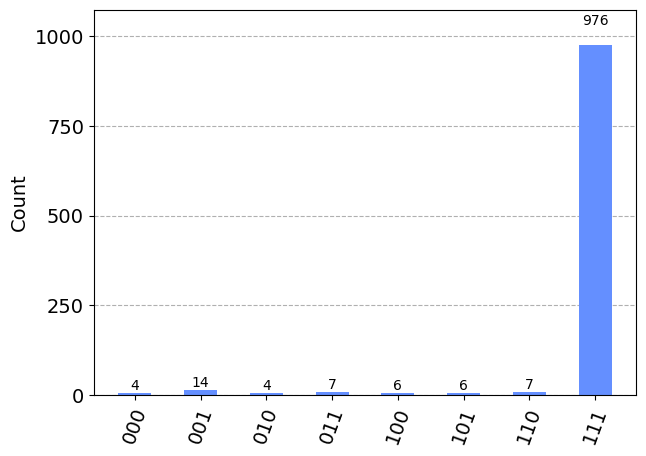

In [22]:
t_qc = transpile(qc, sim)
results = sim.run(t_qc, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

## Summary

1. We introduced Grover's search, a quantum algorithm for unstructured search.
2. Grover's search provides a quadratic speedup compared to classical search.